## This notebook illustrates unfolding using the RooUnfold methods 

In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

rc('text', usetex=True)

Welcome to JupyROOT 6.15/01


In [2]:
from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex

/mnt/c/Users/marratia/Linux/buildroot/lib/ROOT.py:579: UserWarning: "from ROOT import *" is not supported under IPython
  warnings.warn( '"from ROOT import *" is not supported under IPython' )


In [3]:
ROOT.gSystem.Load("/mnt/c/Users/marratia/Linux/RooUnfold/libRooUnfold")
from ROOT import gRandom, TH1, TH1D, TH2D, cout, THStack
#for unfolding
from ROOT import RooUnfoldResponse
from ROOT import RooUnfold
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldSvd
from ROOT import RooUnfoldTUnfold
from ROOT import RooUnfoldBinByBin
from ROOT import RooUnfoldIds

from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex

In [4]:
ROOT.gInterpreter.ProcessLine('#include "MyTUnfoldDensity.h"')


0L

In [5]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [6]:
def getJetData(inputFiles, isMC=False):
    
    cols = []
    scalar = []
  
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')

    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_dphi')
    cols.append('jet_z')
    
    if(isMC):
        cols.append('genjet_p')
        cols.append('genjet_pt')
        cols.append('genjet_qt')
        cols.append('genjet_dphi')
        cols.append('genjet_z')

    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [7]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['jet_p'].mean(), ' mean jet p'
    print df['jet_pt'].mean(), ' mean jet pT'
    print df['jet_pt'].describe()

    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    return

In [8]:
def getData(inputFiles):
    
    cols = []
    scalar = []  
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [9]:
def applyCuts(df):
    temp = df
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'e_pt>10', 'e_pt >10')
    #temp = applyCut(temp, 'x > 0.05', 'x>0.05')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    return temp

In [10]:
def applyCutsJets(df,isMC=False):
    temp = df
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'e_pt>10', 'e_pt >10')
    temp = applyCut(temp, 'jet_pt>5', 'jet_pt>5')
    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
        temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes

In [11]:
df = getData(['data.root'])
df = applyCuts(df)

mc = getData(['mc.root'])
mc = applyCuts(mc)


Processed data.root in 0.5 seconds
0.2 < y < 0.7 170849  fraction kept: 100.0
Q2>150 170849  fraction kept: 100.0
e_pt >10 137246  fraction kept: 80.3

Processed mc.root in 0.1 seconds
0.2 < y < 0.7 118567  fraction kept: 100.0
Q2>150 118567  fraction kept: 100.0
e_pt >10 97889  fraction kept: 82.6


In [12]:
df_jet      = getJetData(['data.root'])
df_jet = applyCutsJets(df_jet)

mc_jet = getJetData(['mc.root'],isMC=True)
mc_jet = applyCutsJets(mc_jet, isMC=True)


Processed data.root in 5.5 seconds
0.2 < y < 0.7 82882  fraction kept: 100.0
Q2>150 82882  fraction kept: 100.0
e_pt >10 70103  fraction kept: 84.6
jet_pt>5 70103  fraction kept: 100.0

Processed mc.root in 6.9 seconds
0.2 < y < 0.7 145313  fraction kept: 100.0
Q2>150 145313  fraction kept: 100.0
e_pt >10 125072  fraction kept: 86.1
jet_pt>5 125072  fraction kept: 100.0


## define variables, binning, etc

In [13]:
#coarsebins = 15
#finebins = 15##15
#minval = 2.5
#maxval = np.pi
#variable    = 'jet_dphi' 
#genvariable = 'genjet_dphi'
#namevariable = r'$\Delta\phi$'

#coarsebins = 7
#finebins = 7
#minval = 0.0
#maxval = 10
#variable = 'jet_qt'
#genvariable = 'genjet_qt'
#namevariable = r'$q_{T}'

#minval = 0.0 
#maxval = 1.0
#variable = 'jet_qtnormept'
#genvariable = 'genjet_qtnormept'


coarsebins = 10
finebins = 10
minval = 0.0
maxval = 1.0
variable = 'jet_qtnormjetpt'
genvariable = 'genjet_qtnormjetpt'
namevariable = r'$q_{T}/p_{T}^{jet}$'

#coarsebins = 15
#finebins = 15
#minval = 0
#maxval = 1.5
#variable = 'jet_z'
#genvariable = 'genjet_z'
#namevariable = r'$z_{jet}$'


binwidth = (maxval - minval)/coarsebins

M = ROOT.TH2D("M", "Response Matrix", coarsebins,minval,maxval, finebins,minval,maxval)
M1 = M.Clone("M1")
M2 = M.Clone("M2")
M1.SetTitle("+1#sigma")
M2.SetTitle("-1#sigma")

scaleup = 1.001
scaledn = 0.999

eptmin = 15
eptmax = 20

## make data selection, split MC in two statistically independent samples

In [14]:
data_cut = df_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))
mc_cut = mc_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))
print len(mc_cut)
msk = np.random.rand(len(mc_cut)) < 0.10
mctest_cut = mc_cut[msk]
mc_cut   = mc_cut[~msk]
print len(mctest_cut)
print len(mc_cut)

29316
2895
26421


<function matplotlib.pyplot.hist>

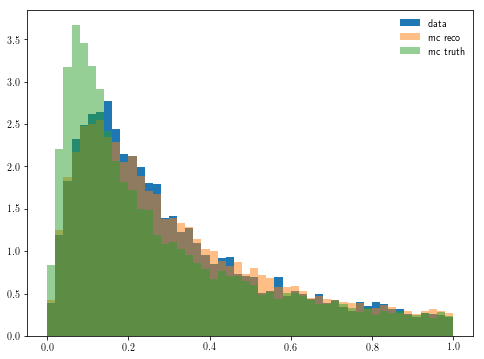

In [15]:
fig = plt.figure(figsize=(8,6))

plt.hist(data_cut[variable],range=(0,maxval),bins=50,normed=True,label='data')
plt.hist(mc_cut[variable],range=(0,maxval),bins=50,normed=True,alpha=0.5,label='mc reco')
plt.hist(mc_cut[genvariable],range=(0,maxval),bins=50, normed=True,alpha=0.5,label =' mc truth')
plt.legend(loc='best', frameon=False)
plt.hist

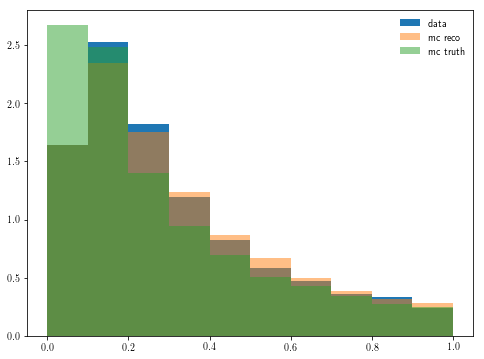

In [16]:
fig = plt.figure(figsize=(8,6))

plt.hist(data_cut[variable],range=(0,maxval),bins=coarsebins,normed=True,label='data')
plt.hist(mc_cut[variable],range=(0,maxval),bins=coarsebins,normed=True,alpha=0.5,label='mc reco')
plt.hist(mc_cut[genvariable],range=(0,maxval),bins=coarsebins, normed=True,alpha=0.5,label =' mc truth')
plt.legend(loc='best', frameon=False)


## Fill response matrix

In [17]:
Npe = len(mc_cut[variable])

response= RooUnfoldResponse(coarsebins, minval, maxval,
                            finebins , minval, maxval);
response.UseOverflow()

for i in np.arange(len(mc_cut[variable])):
    x = mc_cut.iloc[i][variable]
    y = mc_cut.iloc[i][genvariable]
    M.Fill(x, y, 1./Npe)
    response.Fill(x, y);
#
#plt.hist(df_cut['jet_qt'],bins=10,range=(0,10.0),normed=True,alpha=0.9, label='MC reco',histtype='step',lw=2)


## Plot response matrix

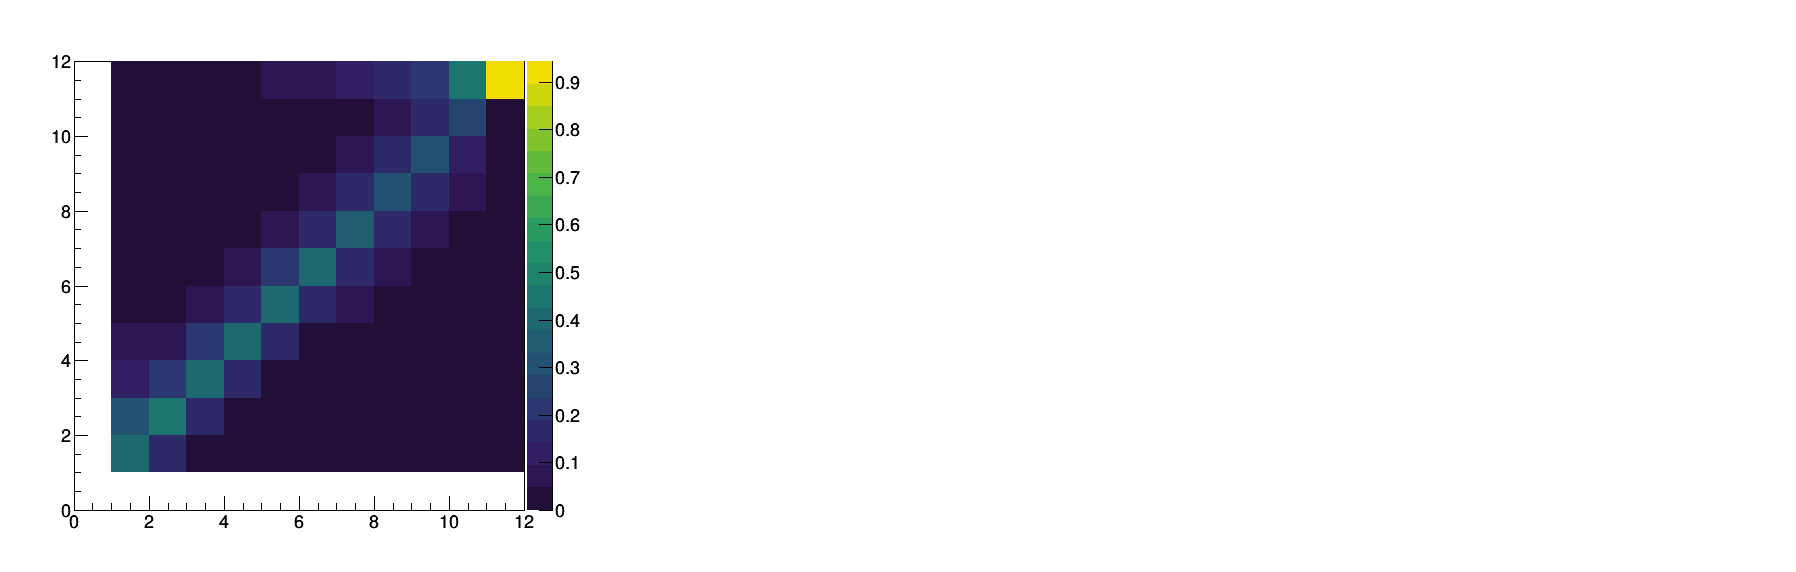

In [18]:
ROOT.gStyle.SetOptStat("")
ROOT.gStyle.SetPalette(ROOT.kViridis);
ROOT.gStyle.SetTitleYOffset(0.85)
ROOT.gStyle.SetEndErrorSize(10)


c0 = ROOT.TCanvas("c0", "c0", 1800, 600)
c0.Divide(3,1)
c0.cd(1)
response.Mresponse().Draw("colz")
c0.Draw()

## fill mc truth and mc reco histograms

In [19]:
h_mcreco = ROOT.TH1D("h_mcreco", "h_mcreco", coarsebins, minval, maxval)
h_mctrue = ROOT.TH1D("h_mctrue", "h_mctrue", finebins, minval, maxval)
   
for i in np.arange(len(mc_cut[variable])):
    h_mctrue.Fill(mc_cut.iloc[i][genvariable])
    h_mcreco.Fill(mc_cut.iloc[i][variable])


## Create data histogram and pseudodata histogram 

In [20]:
h_fakedata = ROOT.TH1D("h_fakedata", "h_fakedata", coarsebins, minval, maxval)   
    
for i in np.arange(len(mctest_cut[variable])):
    h_fakedata.Fill(mctest_cut.iloc[i][variable])
       
h_data = ROOT.TH1D("h_data", "h_data", coarsebins, minval, maxval)   
for i in np.arange(len(data_cut[variable])):
    h_data.Fill(data_cut.iloc[i][variable])

## Plot mc truth, mc reco, data, and pseudodata

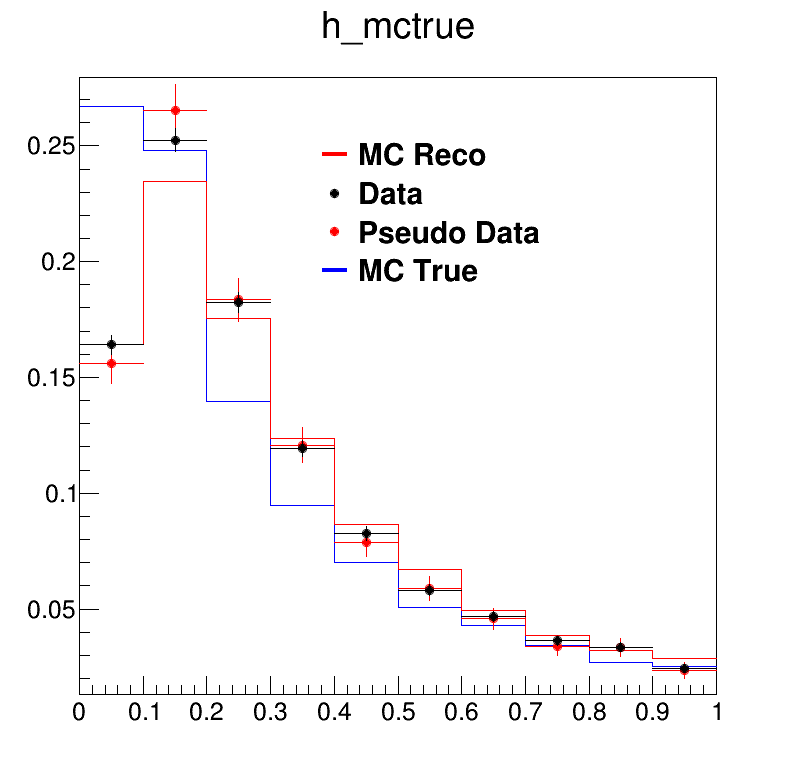

In [21]:
#h_mcreco.SetMarkerStyle(20)
h_data.SetMarkerStyle(20)
h_data.SetMarkerColor(ROOT.kBlack)
h_data.SetLineColor(ROOT.kBlack)

#h_mctrue.SetMarkerStyle(21)
h_fakedata.SetMarkerColor(ROOT.kRed)
h_fakedata.SetLineColor(ROOT.kRed)

h_fakedata.SetLineWidth(1)

h_fakedata.SetMarkerStyle(20)
h_mctrue.SetLineColor(ROOT.kBlue)
h_mcreco.SetLineColor(ROOT.kRed)
#h_fakedata.SetLineColor(ROOT.kBlue)
#h_mctrue.SetLineColor(ROOT.kRed)

creco = ROOT.TCanvas("creco", "creco", 800, 800)
h_mctrue.DrawNormalized()
h_mctrue.SetMinimum(0.0)
h_mcreco.DrawNormalized('same')
h_fakedata.DrawNormalized("e same")
h_data.DrawNormalized("e same")

creco.Draw()

ROOT.gStyle.SetOptStat("")


label = Legend("")
label.Add( h_mcreco, 'MC Reco', 'L')
label.Add(h_data, 'Data','P')
label.Add(h_fakedata, 'Pseudo Data', 'P')
label.Add( h_mctrue, 'MC True', 'L')
label.Draw(.4,.85)


## Plot response matrix and projections

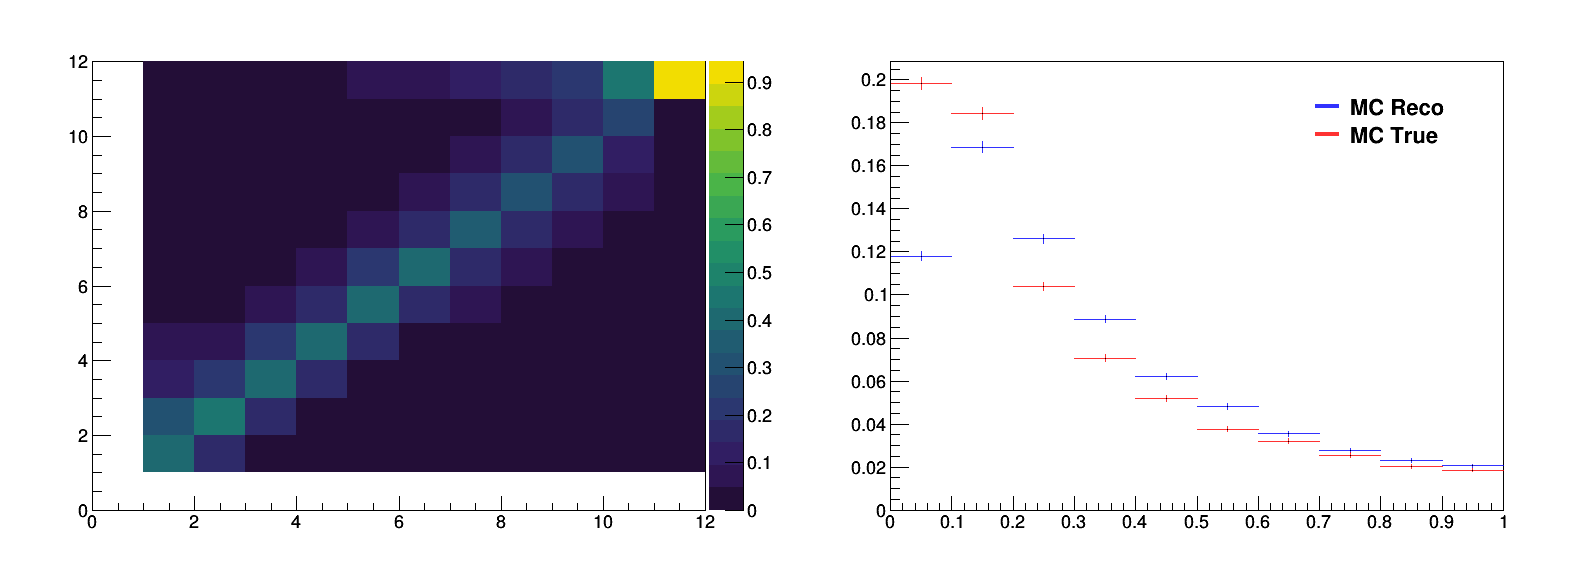

In [22]:
mc_truth = M.ProjectionY()
mc_reco = M.ProjectionX()
mc_truth.SetLineColorAlpha(2,0.8)
mc_reco.SetLineColorAlpha(4,0.8)

##draw mc truth, mc reco, response matrix
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(2)
c.cd(1)
response.Mresponse().Draw("colz")
#responseMatrix.Draw('colz')
#response.Mresponse().SetTitle('Response Matrix; Reconstructed; True')

#ROOT.gPad.SetLogz()
c.cd(2)


label = Legend("")
label.Add(mc_reco,'MC Reco','L')
label.Add(mc_truth,'MC True','L')

hs_mc = ROOT.THStack()
hs_mc.Add(mc_reco)
hs_mc.Add(mc_truth)
hs_mc.Draw('nostack')
#hs_mc.SetTitle(axestitle[variable])

label.Draw(0.65,.87)
c.Draw()

# Define input for unfolding, create dictionaries to store results

In [23]:
data_inputforunfolding = h_data.Clone()

data_unfolded = {}
Covariance = {}
InverseCovariance  = {}
correlation = {}
unfold = {}

# Find appropiate number of iterations for the Bayesian Unfolding

In [24]:
## Computes the global correlation coefficient
def get_averagerho(cov,inversecov):
    nrows= cov.GetNrows()
    ncolumns = cov.GetNcols()
    rhos = []
    for i in range(nrows) :
        #print np.sqrt(1- 1.0/(cov(i,i)*inversecov(i,i)))
        if(cov(i,i)*inversecov(i,i)!=0):
            rhos.append( np.sqrt(1- 1.0/(cov(i,i)*inversecov(i,i))))
        else:
            print 'something messed up with the inverse cov or cov'
    #print rhos
    return np.average(rhos)


def GetCorrelationMatrix ( cov, name):

    nrows= cov.GetNrows()
    ncolumns = cov.GetNcols()
    
    h= ROOT.TH2D (name, "", nrows, 0, nrows, ncolumns, 0, ncolumns);
    h.SetAxisRange (-1.0, 1.0, "Z")
    for i in range(nrows) :
        for j in range(ncolumns) :
            Viijj= cov(i,i)*cov(j,j)
            if Viijj>0.0: h.SetBinContent (i+1, j+1, cov(i,j)/ROOT.TMath.Sqrt(Viijj))
            
    return h

## Do check convergence of iterative unfolding procedure. Check Correlation matrices and the unfolded result. We expect the correlation matrix to show **negative** correlation between adjacent bins. If we see too much large positive correlations, it means that the unfolding has not converged yet. 

In [25]:
c = ROOT.TCanvas('c','c',1600,1600)
c.Divide(4,8)
for i in range(1,30):
    unfold['Bayes_iter%i'%i] = RooUnfoldBayes(response, data_inputforunfolding, i)
    h = unfold['Bayes_iter%i'%i].Hreco();
    Covariance['Bayes_iter%i'%i] = unfold['Bayes_iter%i'%i].Ereco();
    InverseCovariance['Bayes_iter%i'%i] = unfold['Bayes_iter%i'%i].Wreco();
    correlation['Bayes_iter%i'%i] = GetCorrelationMatrix(Covariance['Bayes_iter%i'%i], 'Bayes_iter%i'%i)
    
    #c.cd(i-2)#i-2
    #h.Scale(1.0/h.Integral())
    #h.Draw()
    #h.SetLineColor(i)
    
#c.Draw()

Now unfolding...
Iteration : 0
Chi^2 of change 53.5351
Calculating covariances due to number of measured events
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 53.5351
Iteration : 1
Chi^2 of change 5.74754
Calculating covariances due to number of measured events
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 53.5351
Iteration : 1
Chi^2 of change 5.74754
Iteration : 2
Chi^2 of change 1.49738
Calculating covariances due to number of measured events
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Now unfolding...
Iteration : 0
Chi^2 of change 53.5351
Iteration : 1
Chi^2 of change 5.74754
Iteration : 2
Chi^2 of change 1.49738
Iteration : 3
Chi^2 of change 0.59206
Calculating covariances due to number o

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov or cov
something messed up with the inverse cov

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


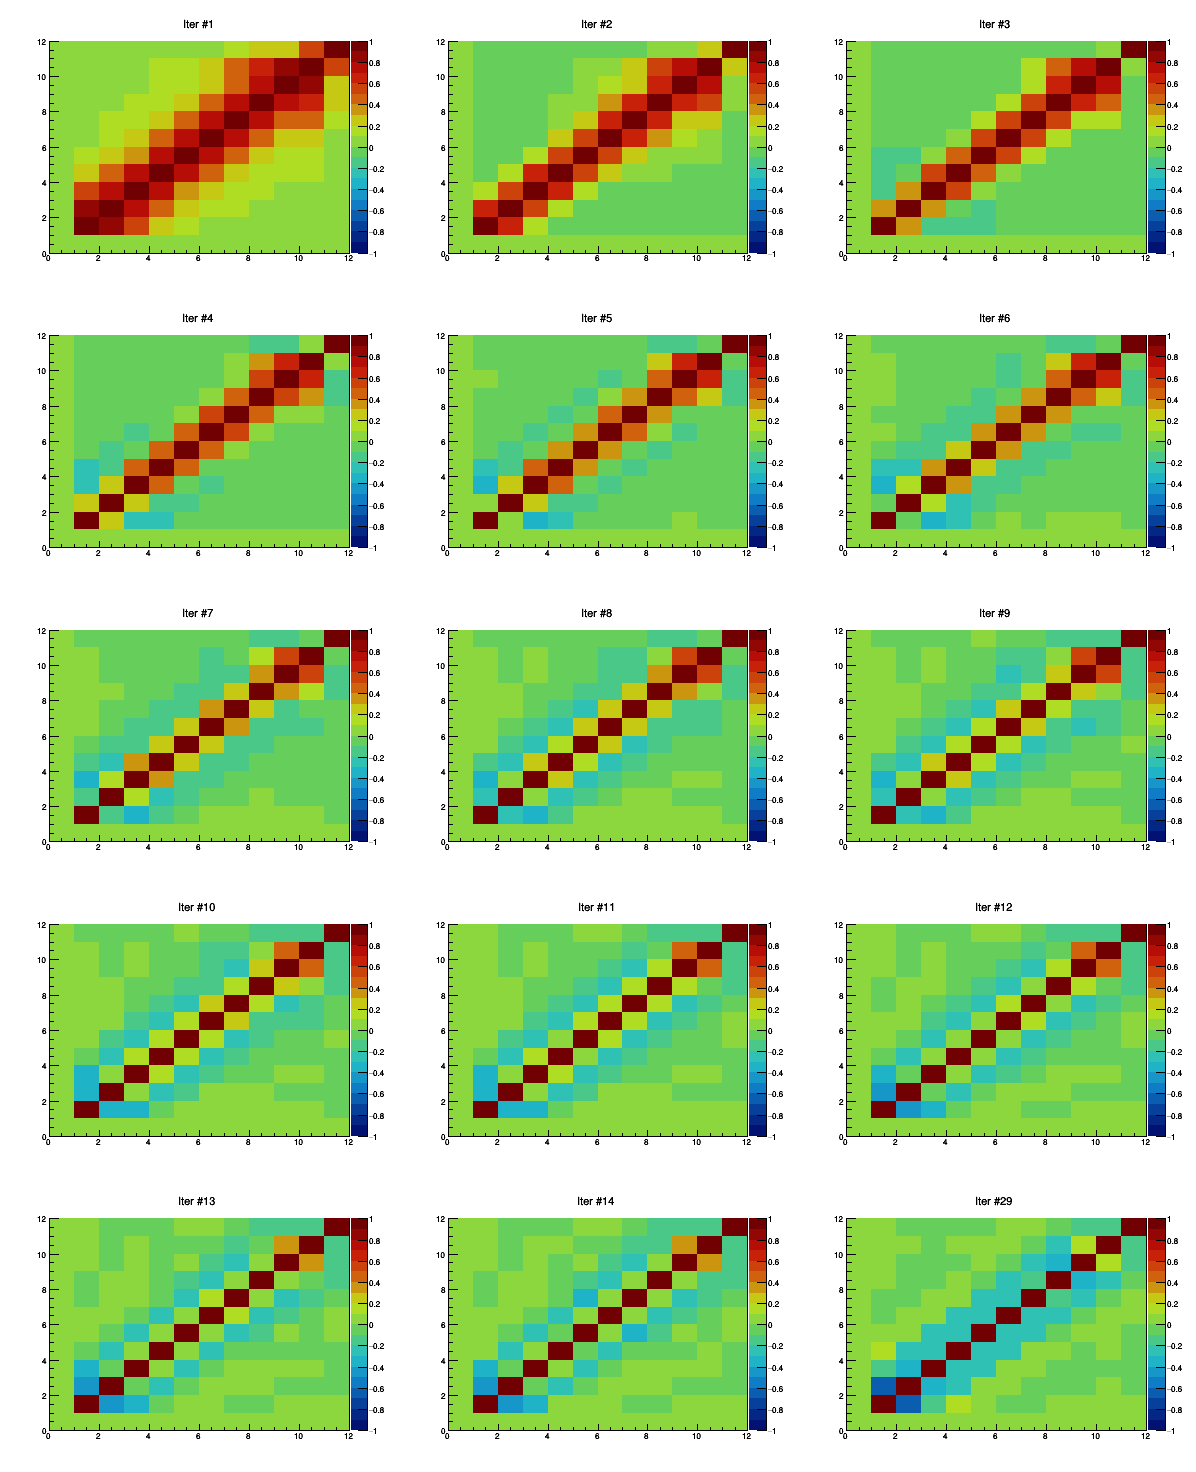

In [26]:
c = ROOT.TCanvas('c','c',1200,1500)
c.Divide(3,5)
ROOT.gStyle.SetPalette(ROOT.kRainBow);

rho = []
iteration = []
for i in range(1,30):
    c.cd(i)
    correlation['Bayes_iter%i'%i].SetTitle('Iter #%i'%i)
    correlation['Bayes_iter%i'%i].Draw('colz')
    #Covariance['Bayes_iter%i'%i].SetTitle('Iter #%i'%i)
    #Covariance['Bayes_iter%i'%i].Draw('colz')
    
    rho.append(get_averagerho(Covariance['Bayes_iter%i'%i],InverseCovariance['Bayes_iter%i'%i]))
    iteration.append(i)
#print rho
c.Draw()

## Average global correlation coefficient vs number of iterations
## the global correlation coefficient for bin i is defined as
## rho_i = sqrt[ 1 - 1/(Cov_ii*InverseCov_ii)]
## Take average of all rho_i and stsudy dependence of the number of iterations. Should take the minimum.

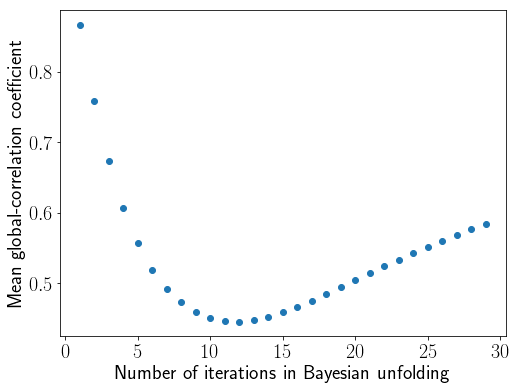

The number of iterations that results in the minimum average global correlation coefficient is 11
The minimum average global correlation coefficient is 0.45


In [27]:
fig = plt.figure(figsize=(8,6))
plt.plot(iteration,rho,'o')
plt.xlabel('Number of iterations in Bayesian unfolding',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()
print 'The number of iterations that results in the minimum average global correlation coefficient is', np.argmin(rho)
print 'The minimum average global correlation coefficient is %2.2f'%min(rho)

nbayes_iter = np.argmin(rho)


## Perform unfolding with optimal number of iterations (found above)

In [28]:


unfold['Bayes'] = RooUnfoldBayes(response, data_inputforunfolding, nbayes_iter)
#RooUnfoldTUnfold(response, data_inputforunfolding) # 
unfold['Bayes'].IncludeSystematics()


data_unfolded['Bayes'] = unfold['Bayes'].Hreco()
Covariance['Bayes'] = unfold['Bayes'].Ereco();
#unfold['Bayes'].PrintTable (cout, mc_truth)


Now unfolding...
Iteration : 0
Chi^2 of change 53.5351
Iteration : 1
Chi^2 of change 5.74754
Iteration : 2
Chi^2 of change 1.49738
Iteration : 3
Chi^2 of change 0.59206
Iteration : 4
Chi^2 of change 0.33427
Iteration : 5
Chi^2 of change 0.245379
Iteration : 6
Chi^2 of change 0.204927
Iteration : 7
Chi^2 of change 0.180219
Iteration : 8
Chi^2 of change 0.161861
Iteration : 9
Chi^2 of change 0.146872
Iteration : 10
Chi^2 of change 0.134125
Calculating covariances due to number of measured events
Calculating covariance due to unfolding matrix...


## Error matrix

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


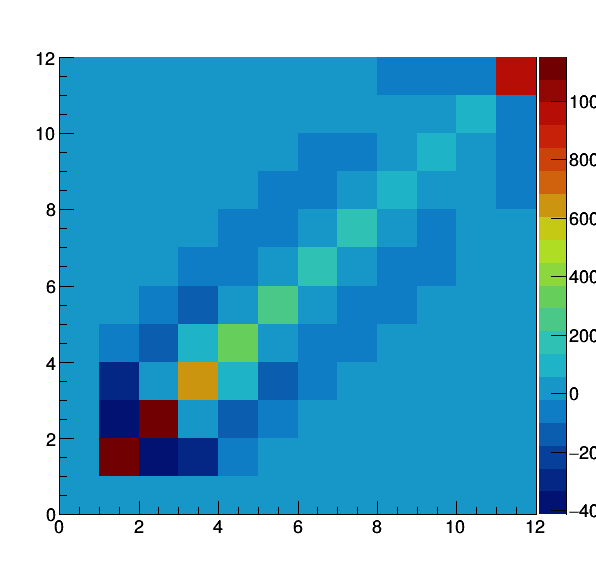

In [29]:
c = ROOT.TCanvas('c','c',600,600)
Covariance['Bayes'].Draw("colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


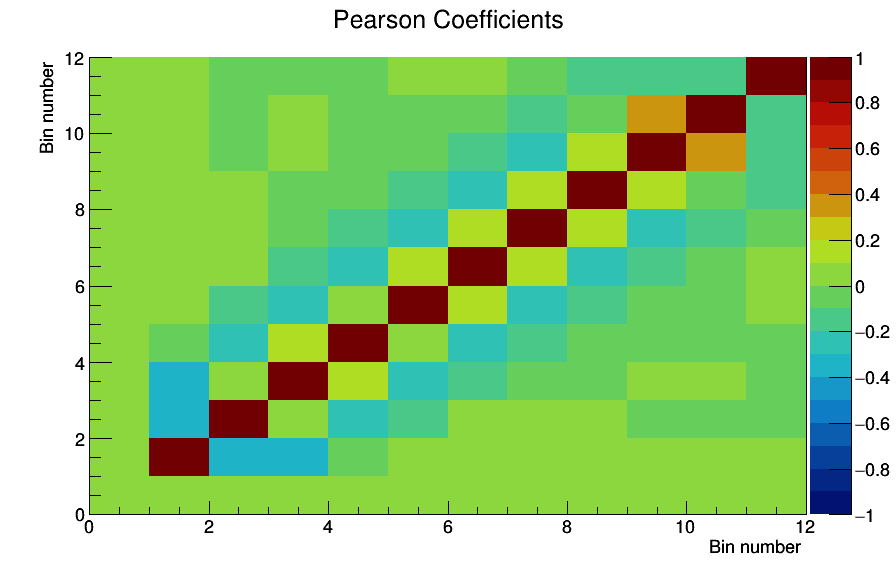

In [30]:
ROOT.gStyle.SetPalette(ROOT.kRainBow);

c = ROOT.TCanvas('c','c',900,600)
correlation = {}

correlation['Bayes'] = GetCorrelationMatrix(Covariance['Bayes'], 'Bayes')
correlation['Bayes'].Draw('colz')
#correlation['Bayes'].GetXaxis().SetRangeUser(1,7)
#correlation['Bayes'].GetYaxis().SetRangeUser(1,7)
correlation['Bayes'].GetXaxis().SetTitle('Bin number')
correlation['Bayes'].GetYaxis().SetTitle('Bin number')
correlation['Bayes'].SetTitle('Pearson Coefficients')
correlation['Bayes'].GetZaxis().SetRangeUser(-1.0,1.0)
c.Draw()

## Compare data after unfolded, data at reconstructed level, and MC truth

Bayes   1   0.05  0.267  0.011
Bayes   2   0.15  0.279  0.010
Bayes   3   0.25  0.147  0.008
Bayes   4   0.35  0.087  0.006
Bayes   5   0.45  0.062  0.005
Bayes   6   0.55  0.040  0.004
Bayes   7   0.65  0.040  0.004
Bayes   8   0.75  0.033  0.004
Bayes   9   0.85  0.026  0.003
Bayes   10   0.95  0.019  0.002
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[0.2674098  0.27927066 0.14660498 0.0865021  0.0622051  0.04022091
 0.03960141 0.03308562 0.0257484  0.01935103]
[0.01057538 0.01023997 0.0078817  0.00591917 0.00522103 0.0039217
 0.00405877 0.00352983 0.00336185 0.00240906]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


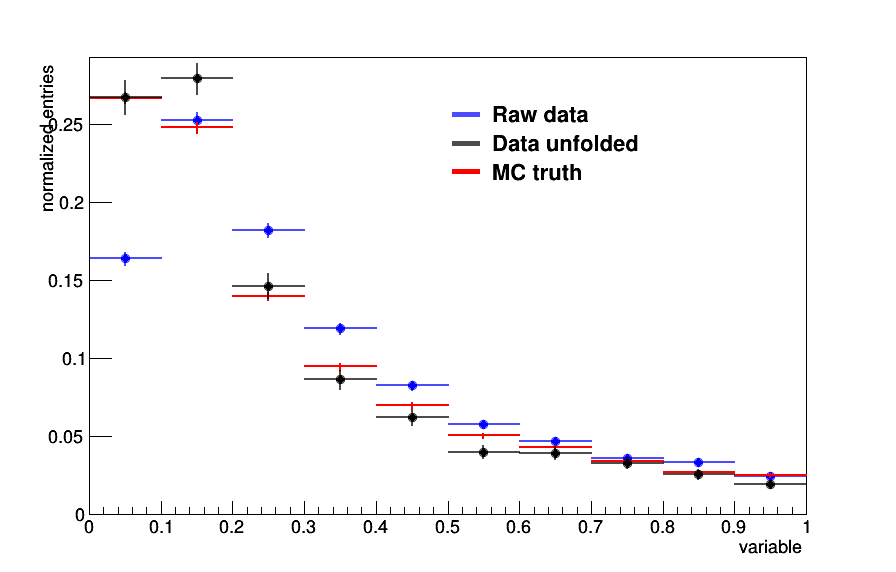

In [31]:
c = ROOT.TCanvas('c','c',900,600)

label = Legend("")
alpha = 0.7
hstack = ROOT.THStack()
h_data.SetLineWidth(2)
h_data.SetLineColorAlpha(4,alpha)
h_data.SetMarkerColor(4)
mc_truth.SetLineColor(2)
mc_truth.SetLineWidth(2)
mc_truth.SetMarkerColor(2)

h_data.SetMarkerStyle(20)

color = {}
color['Bayes'] = 1

h_data.Scale(1.0/h_data.Integral())
mc_truth.Scale(1.0/mc_truth.Integral())


result_x = np.array([])
result_y = np.array([])
result_erry = np.array([])

for key in ['Bayes']:
    data_unfolded[key].SetMarkerStyle(20)
    data_unfolded[key].SetLineWidth(2)
    data_unfolded[key].SetLineColorAlpha(color[key],alpha)
    data_unfolded[key].SetMarkerColor(color[key])
    data_unfolded[key].Scale(1.0/data_unfolded[key].Integral())

    for i in range(1,data_unfolded[key].GetNbinsX()+1):
        print key, ' ' , i , ' ', data_unfolded[key].GetBinCenter(i), ' %2.3f'%data_unfolded[key].GetBinContent(i), ' %2.3f'%data_unfolded[key].GetBinError(i)
        result_x = np.append(result_x, data_unfolded[key].GetBinCenter(i))
        result_y = np.append(result_y, data_unfolded[key].GetBinContent(i))
        result_erry = np.append(result_erry, data_unfolded[key].GetBinError(i))
hstack.Add(h_data)
hstack.Add(mc_truth)
hstack.Add(data_unfolded['Bayes'])
label.Add(h_data, 'Raw data', 'L')
label.Add(data_unfolded['Bayes'],'Data unfolded','L')      
label.Add(mc_truth, 'MC truth', 'L')

hstack.SetTitle('; variable; normalized entries')
hstack.Draw('nostack')
hstack.GetYaxis().SetNdivisions(6)
label.Draw(.5,.85)

c.Draw()
print result_x
print result_y
print result_erry
#c.SaveAs('Unfoldedresult%s.pdf'%(datatype))

## Closure test: feed pseudodata (MC) to the unfolding and test whether it is compatible with the truth distribution

In [32]:
#data_inputforunfolding = h_data.Clone()
data_inputforunfolding = h_fakedata.Clone()
closure = RooUnfoldBayes(response, data_inputforunfolding, nbayes_iter).Hreco();


Now unfolding...
Iteration : 0
Chi^2 of change 3.86532
Iteration : 1
Chi^2 of change 0.571959
Iteration : 2
Chi^2 of change 0.273362
Iteration : 3
Chi^2 of change 0.189128
Iteration : 4
Chi^2 of change 0.149825
Iteration : 5
Chi^2 of change 0.125284
Iteration : 6
Chi^2 of change 0.107284
Iteration : 7
Chi^2 of change 0.0930795
Iteration : 8
Chi^2 of change 0.0814968
Iteration : 9
Chi^2 of change 0.0718851
Iteration : 10
Chi^2 of change 0.0638144
Calculating covariances due to number of measured events


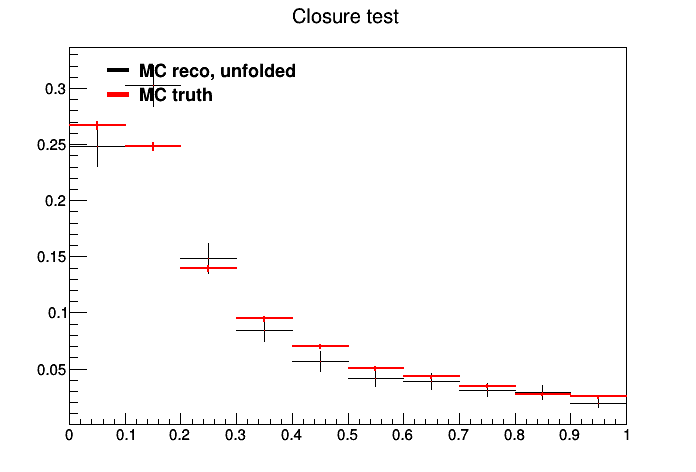

In [33]:
c = ROOT.TCanvas()
closure.SetLineColor(1)
closure.SetMarkerColor(2)
closure.Scale(1/closure.Integral())
closure.SetTitle('Closure test')
closure.Draw()
mc_truth.Draw('same')
label = Legend("")
label.Add(closure, 'MC reco, unfolded', 'L')
label.Add(mc_truth, 'MC truth' ,     'L')
label.Draw(.15,.90)

c.Draw()

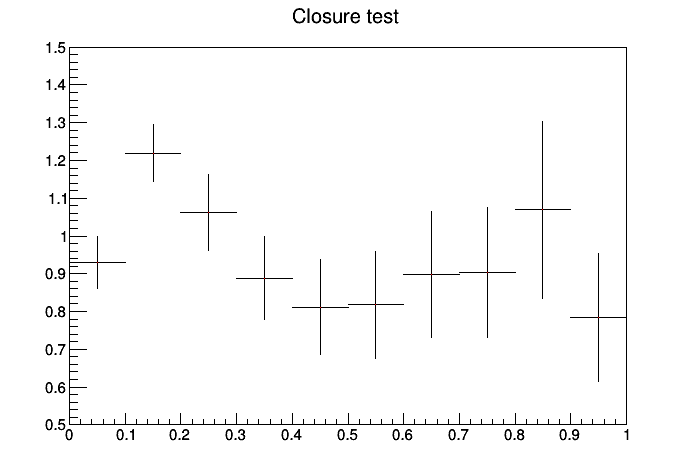

In [34]:
temp = closure.Clone('temp')
temp.Divide(mc_truth)
c = ROOT.TCanvas()
temp.Draw()
temp.SetMinimum(0.5)
temp.SetMaximum(1.5)
temp.SetTitle('Closure test')
c.Draw()

# Multiply the unfolded result by the response matrix, compare with data. This is the "refolded check"

0.163782229575
0.241402469167
0.17744683685
0.118506033426
0.078855168724
0.0587453286023
0.0444482847192
0.0353241177083
0.0301451009394
0.0278617715866
0.469527121678


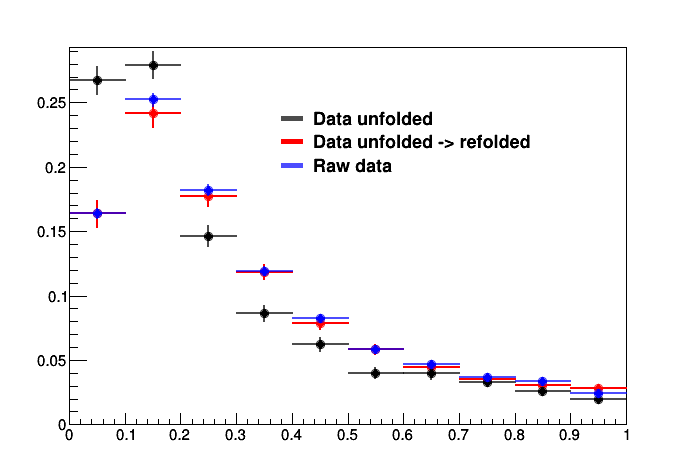

In [87]:
c = ROOT.TCanvas()

#response.Mresponse().Draw("colz")
    
nrows= response.Mresponse().GetNrows()
ncolumns = response.Mresponse().GetNcols()
    
##print nrows
#print ncolumns
temp = 0

refolded = data_unfolded['Bayes'].Clone('refolded')

##element #1 will be:
for n in range(1,nrows):
    temp = 0
    for i in range(1,nrows):
        #print 'element #%i'%i, ' '  , response(i,n)
        temp = temp +  response(n,i)*data_unfolded['Bayes'].GetBinContent(i)
    print temp
    refolded.SetBinContent(n,temp)
#c.Draw()

#print type(data_unfolded['Bayes'])

#for i in range(1,nrows):
    #print data_unfolded['Bayes'].GetBinContent(i)
    
    
c = ROOT.TCanvas()

refolded.SetLineColor(2)
refolded.SetMarkerColor(2)
hs = ROOT.THStack()
hs.Add(refolded)
hs.Add(data_unfolded['Bayes'])
hs.Add(h_data)
label = Legend("")
label.Add(data_unfolded['Bayes'],'Data unfolded','L')      
label.Add(refolded, 'Data unfolded -> refolded', 'L')
label.Add(h_data, 'Raw data', 'L')


hs.Draw('nostack')

label.Draw(0.4,0.8)
c.Draw()

# Final plot, unfolded result vs MC truth

17.127508  mean lepton pt
0.37809396  mean inelasticity
20.853493  mean jet p
14.594749  mean jet pT
count    29316.000000
mean        14.594749
std          5.786974
min          5.000011
25%         10.167954
50%         14.656549
75%         18.230238
max         49.601570
Name: jet_pt, dtype: float64
0.0135342395  mean x
500.09366  mean Q2
count    29316.000000
mean       500.093658
std        153.255875
min        281.785370
25%        390.239647
50%        465.341583
75%        568.719543
max       1287.933350
Name: Q2, dtype: float64
###########


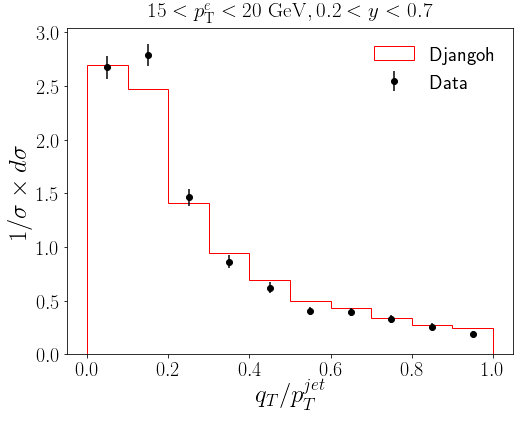

In [85]:
rc('text', usetex=True)


fig = plt.figure(figsize=(8,6))


df_cut = mc_jet.query('e_pt > %2.2f and e_pt<%2.2f'%(eptmin,eptmax))
printSummary(df_cut)
print '###########'
    
plt.hist(df_cut[genvariable],bins=coarsebins,range=(minval,maxval),normed=True,histtype='step',color='red',label='Djangoh')    
plt.errorbar(x=result_x,y=np.divide(result_y,binwidth), yerr=np.divide(result_erry,binwidth), fmt='o',ls='none',label='Data',color='black')

plt.xlabel(namevariable, fontsize=25)
plt.ylabel(r'$1/\sigma \times d\sigma$ ', fontsize=25)
#plt.tick_params('both',labelsize=20)

plt.title(r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f \mathrm{~GeV}, 0.2<y<0.7$'%(eptmin,eptmax),fontsize=21)
#plt.text(0.05,1.2, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(eptmin,eptmax) + '$\ \mathrm{ GeV}$ \n' +
#                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=21)

plt.legend(loc='best',frameon=False)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

#plt.yscale('log')
plt.legend(prop={'size': 20}, frameon=False, loc='best')
#plt.legend(loc='best',frameon=False)
plt.savefig('qtplot.png', bbox_inches='tight')
plt.savefig('qtplot.pdf', bbox_inches='tight')

